# Results of Simulation of SPD matrices

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))
import pickle 
import numpy as np
import pandas as pd
from pyfrechet.metric_spaces import MetricData, LogCholesky, log_chol_to_spd, spd_to_log_chol

import matplotlib.pyplot as plt
import seaborn as sns

INFO: Using numpy backend


In [2]:
coverages=[]
alpha=0.05
M=LogCholesky(dim=2)

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    Dalpha=np.percentile(result['oob_errors'], (1-alpha)*100)
    coverages.append(np.mean(M.d(result['test_predictions'], 
                                 result['y_test_data']) <= Dalpha))

    infile.close()

In [3]:
print(len(coverages))
print(np.mean(coverages))

2332
0.9383190394511148


In [4]:
results=[]

for file in os.listdir(os.path.join(os.getcwd(), 'results')):
    infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
    result=pickle.load(infile)

    results.append(result)

    infile.close()

len(results)

2332

In [5]:
nus=[1.5, 2, 2.5, 3, 4, 5, 6]

def coverage_results(nus: list, sign_level: float=0.05) -> pd.DataFrame:
    
    coverage_df=pd.DataFrame(columns=['sample_index', 'train_size', 'df', 'coverage', 'OOB_quantile'])

    for file in os.listdir(os.path.join(os.getcwd(), 'results')):
        infile=open(os.path.join(os.getcwd(), 'results/'+file), 'rb')
        result=pickle.load(infile)
        infile.close()

        Dalpha=np.percentile(result['oob_errors'], (1-sign_level)*100)
        coverage_df=pd.concat([coverage_df, 
                               pd.DataFrame({'sample_index': int(file.split('_')[1][4:]),
                                             'train_size': int(file.split('_')[2][1:]),
                                             'df': nus[int(file.split('_')[3][2:])-1],
                                             'coverage': np.mean(M.d(result['test_predictions'], result['y_test_data']) <= Dalpha),
                                             'OOB_quantile': Dalpha}, index=pd.RangeIndex(0,1))], 
                                ignore_index=True)
        
    coverage_df['train_size']=coverage_df['train_size'].astype('int')
    coverage_df['sample_index']=coverage_df['sample_index'].astype('int')
        
    return coverage_df

sign_level=0.05
coverage_df=coverage_results(nus=nus, sign_level=sign_level)
print(coverage_df.info())
coverage_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332 entries, 0 to 2331
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample_index  2332 non-null   int32  
 1   train_size    2332 non-null   int32  
 2   df            2332 non-null   float64
 3   coverage      2332 non-null   float64
 4   OOB_quantile  2332 non-null   float64
dtypes: float64(3), int32(2)
memory usage: 73.0 KB
None


,sample_index,train_size,df,coverage,OOB_quantile
0,100,100,1.5,0.91,3.684920
1,100,100,2.0,0.95,2.513346
2,100,100,2.5,0.92,2.042080
3,100,100,3.0,0.90,1.775709
4,100,100,4.0,0.95,1.302275
...,...,...,...,...,...
2327,9,50,2.5,0.93,1.931415
2328,9,50,3.0,0.99,2.086024
2329,9,50,4.0,0.77,0.989140
2330,9,50,5.0,0.97,1.246569


In [6]:
coverage_df.describe()

,sample_index,train_size,df,coverage,OOB_quantile
count,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000
mean,51.833190,210.227273,3.430746,0.938319,2.099824
std,29.484314,173.358056,1.521555,0.034935,1.161549
min,1.000000,50.000000,1.500000,0.720000,0.819089
25%,26.000000,50.000000,2.000000,0.920000,1.245833
50%,50.000000,100.000000,3.000000,0.940000,1.724165
75%,78.000000,200.000000,5.000000,0.960000,2.518235
max,100.000000,500.000000,6.000000,1.000000,7.149987


In [25]:
coverage_df[(coverage_df.train_size==50) & (coverage_df.df==2.5)].shape

(84, 5)

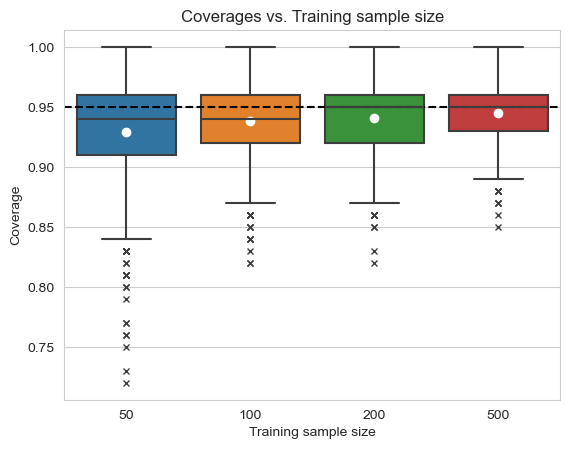

In [7]:
sns.set_style("whitegrid")

plt.figure()
sns.boxplot(data=coverage_df, x='train_size', y='coverage', hue='train_size', palette=sns.color_palette(),
            flierprops={"marker": "x"}, dodge=False)
x_ticks, _=plt.xticks()
for i in range(len(x_ticks)):
    mean=coverage_df[coverage_df.train_size==sorted(coverage_df['train_size'].unique())[i]]['coverage'].mean()
    plt.plot(x_ticks[i], mean, marker='o', color='white')
plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
plt.legend().remove()
plt.title('Coverages vs. Training sample size')
plt.xlabel('Training sample size')
plt.ylabel('Coverage')
plt.show()

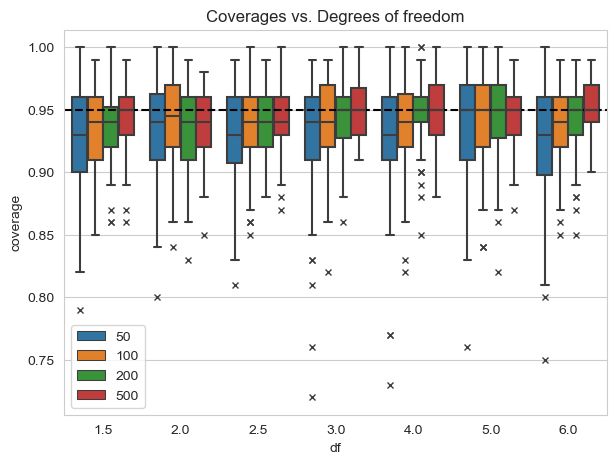

In [9]:
plt.figure(figsize=(7,5))
sns.boxplot(data=coverage_df, x='df', y='coverage', hue='train_size', palette=sns.color_palette(),
            flierprops={'marker':'x'}, dodge=True)
plt.title('Coverages vs. Degrees of freedom')
plt.axhline(y=1-sign_level, color='black', linestyle='dashed')
plt.legend()#.remove()
plt.show()

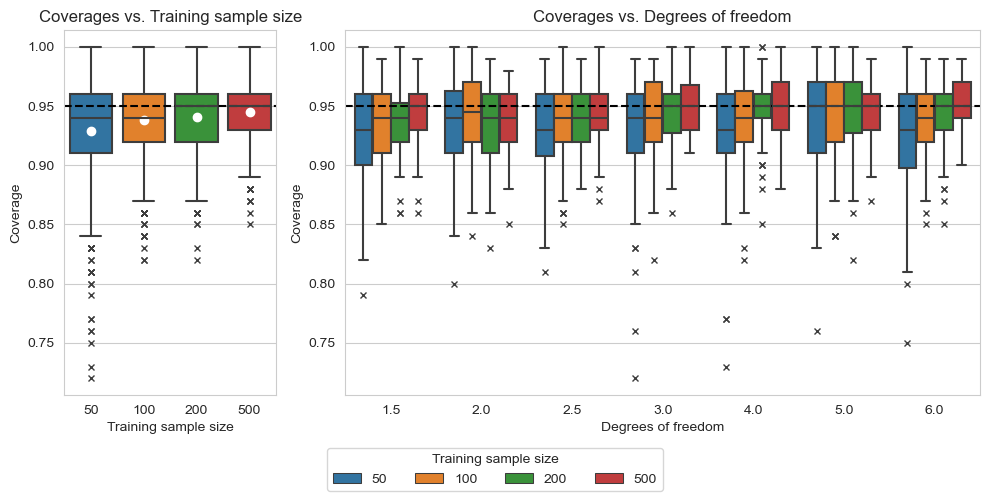

In [11]:
sns.set_style('whitegrid')
fig, axs=plt.subplots(1,2, figsize=(10,5), gridspec_kw={'width_ratios': [1,3]})

sns.boxplot(data=coverage_df, x='train_size', y='coverage', hue='train_size', 
            palette=sns.color_palette(), ax=axs[0], flierprops={"marker": "x"}, dodge=False)
x_ticks=axs[0].get_xticks()
for i in range(len(x_ticks)):
    mean=coverage_df[coverage_df.train_size==sorted(coverage_df['train_size'].unique())[i]]['coverage'].mean()
    axs[0].plot(x_ticks[i], mean, marker='o', color='white')
axs[0].axhline(y=1-sign_level, color='black', linestyle='dashed')
axs[0].set_title('Coverages vs. Training sample size')
axs[0].set_xlabel('Training sample size')
axs[0].set_ylabel('Coverage')
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend().remove()

sns.boxplot(data=coverage_df, x='df', y='coverage', hue='train_size', palette=sns.color_palette(),
            flierprops={"marker": "x"}, ax=axs[1], dodge=True)
axs[1].axhline(y=1-sign_level, color='black', linestyle='dashed')
axs[1].legend().remove()
axs[1].set_title('Coverages vs. Degrees of freedom')
axs[1].set_xlabel('Degrees of freedom')
axs[1].set_ylabel('Coverage')

fig.legend(labels=labels, handles=handles, loc="lower center", ncol=4,
           title='Training sample size')
plt.tight_layout()
fig.subplots_adjust(bottom=0.2)
plt.show()

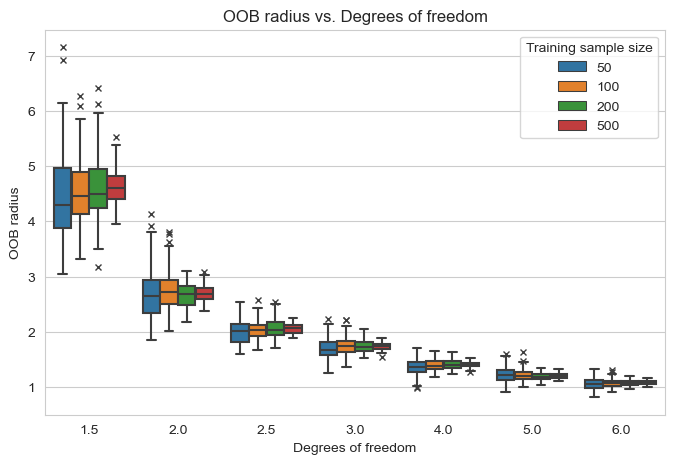

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(data=coverage_df, x='df', y='OOB_quantile', hue='train_size', palette=sns.color_palette(),
            flierprops={'marker':'x'})
plt.title('OOB radius vs. Degrees of freedom')
plt.xlabel('Degrees of freedom')
plt.ylabel('OOB radius')
plt.legend(title='Training sample size')#.remove()
plt.show()